In [10]:
import igraph
import matplotlib.pyplot as plt
import numpy as np
from os import path
import pandas as pd
import seaborn as sns
from selfregulation.utils.utils import get_behav_data
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from selfregulation.utils.r_to_py_utils import GPArotation, missForest, psychFA
from fancyimpute import SoftImpute
%matplotlib inline

# Calculate best number of components based on CV ML (SKlearn)

### Load Data

Load both cleaned and imputed data. Set up a helper function to quickly impute data within the Kfold split. Can't use data where imputation was performed over the whole dataset as there will be data leakage between training and test.

In [3]:
datafile = 'Complete_01-16-2017'
# load data
# imputed data
imputed_data = get_behav_data(dataset=datafile, file = 'meaningful_variables_imputed.csv')
imputed_task_data = get_behav_data(dataset=datafile, file = 'taskdata_imputed.csv')
imputed_survey_data = imputed_data.drop(imputed_task_data.columns, axis = 1)
imputed_datasets = {'survey': imputed_survey_data, 'task': imputed_task_data, 'complete': imputed_data}
# cleaned data 
cleaned_data = get_behav_data(dataset=datafile, file = 'meaningful_variables_clean.csv')
cleaned_task_data = get_behav_data(dataset=datafile, file = 'taskdata_clean.csv')
cleaned_survey_data = cleaned_data.drop(cleaned_task_data.columns, axis = 1)
cleaned_datasets = {'survey': cleaned_survey_data, 'task': cleaned_task_data, 'complete': cleaned_data}

results = {'survey': {}, 'task': {}, 'complete': {}}

Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_01-16-2017
Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_01-16-2017
Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_01-16-2017
Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_01-16-2017


### Define Helper functions

In [8]:
# using for speed, for the time being
def SoftImpute_df(data):
    imputed_mat = SoftImpute(verbose=False).complete(data)
    return pd.DataFrame(data=imputed_mat, columns=data.columns, index=data.index)

def run_FA(n_components,data,cv):
    fa=FactorAnalysis(n_components)
    scores = []
    # cross-validate fit across different train/test splits
    for train_index, test_index in cv.split(data.values):
        data_train, data_test = data.iloc[train_index], \
                                data.iloc[test_index]
        # Impute (replace with missForest later)
        imputed_train = SoftImpute_df(data_train)
        imputed_test = SoftImpute_df(data_test)
        # Scale data
        scaler = StandardScaler()
        scaled_train = scaler.fit_transform(imputed_train)
        scaled_test = scaler.transform(imputed_test)
        # fit model on training
        fa.fit(scaled_train)
        # score on test set
        scores.append(fa.score(scaled_test))
    #average score across kfolds
    score = np.mean(scores)
    return score, fa

def find_optimal_components(data, method='sklearn', cv=None):
    if method == 'sklearn':
        assert cv, "Must Supply a CV if using sklearn"
        # find best number of components
        n_components = range(1,12)
        best_c = 0
        component_scores = []
        for c in n_components:
            score, fa = run_FA(c,data,cv)
            component_scores.append(score)
        best_c = np.argmax(component_scores)+1
        print('Best Component: ', best_c)
        return best_c, component_scores
    elif method == 'psych':
        BICs = []
        outputs = []
        n_components = range(1,12)
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)
        for c in n_components:
            fa, output = psychFA(scaled_data, c, method='ml')
            BICs.append(output['BIC'])
            outputs.append(output)
        best_c = np.argmin(BICs)+1
        print('Best Component: ', best_c)
        return best_c, BICs

### Determine optimal number of factors
Two methods

Sklearn using cross-validated prediction
R's Psych package looking for best fitting model across all the data, penalized for complexity (BIC)

Dataset: task
Best Component:  11
Dataset: survey
Best Component:  11
Dataset: complete
Best Component:  11


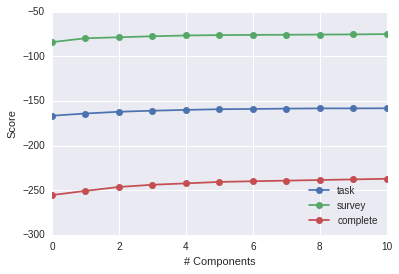

In [7]:
kf = KFold(n_splits = 4)
for label,data in cleaned_datasets.items():
    print('Dataset: %s' % label)
    best_c, scores= find_optimal_components(data, kf)
    results[label]['sklearn_best_c'] = best_c
    results[label]['CV_scores'] = scores
    
for score in [d['CV_scores'] for d in results.values()]:
    plt.plot(range(len(score)),score, '-o')
plt.legend(results.keys(), loc = 'best')
plt.xlabel('# Components')
plt.ylabel('Score')

### Calculate best number of components using BIC (R Psych package)

Dataset: task


/home/ian/anaconda2/envs/py34/lib/python3.4/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required namespace: GPArotation

  warnings.warn(x, RRuntimeWarning)


Best Component:  8
Dataset: survey
Best Component:  11
Dataset: complete
Best Component:  10


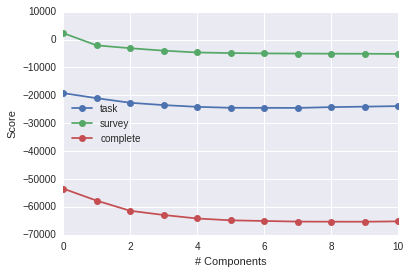

In [9]:
for label,data in imputed_datasets.items():
    print('Dataset: %s' % label)
    best_c, BICs = find_optimal_components(data, method='psych')
    results[label]['psych_best_c'] = best_c
    results[label]['psych_BICs'] = BICs
    
for bic in [d['psych_BICs'] for d in results.values()]:
    plt.plot(range(len(bic)),bic, '-o')
plt.legend(results.keys(), loc = 'best')
plt.xlabel('# Components')
plt.ylabel('Score')

# Interpret Factor Analysis Solutions
Above we found that the best number of components were as follows:

**SKlearn**:

Task: {{results['task']['sklearn_best_c']}}

Survey: {{results['survey']['sklearn_best_c']}}

Complete: {{results['complete']['sklearn_best_c']}}

**Psych**:

Task: {{results['task']['psych_best_c']}}

Survey: {{results['survey']['psych_best_c']}}

Complete: {{results['complete']['psych_best_c']}}

Because psych performs rotation, is more widely used, we will use that as our main analysis. All analyses will be repeated with the sklearn pipeline as well. First we will look at the best number of components, then we will look at the solution at each dimensionality and plot the relationships between dimensions

## Interpret best components (Psych)

Note: percent variance explained is very low for all these models...

### Complete

For EFA using the psych package, the optimal factor structure for the complete dataset settled on 2 dimensions as optimal.

In [ ]:
complete_results = results['complete']
best_c = complete_results['psych_best_c']
data = imputed_datasets['complete']
fa, output = psychFA(data, best_c)

In [ ]:
### Print top variables for each factor
def print_top_factors(fa_output, n = 4):
    # number of variables to display
    loading_df = pd.DataFrame(fa_output['loadings'], index=data.columns)
    for i,column in loading_df.iteritems():
        sort_index = np.argsort(abs(column))[::-1] # descending order
        top_vars = column[sort_index][0:n]
        print('\nFACTOR %s' % i)
        print(top_vars)
    return loading_df
        
loading_df = print_top_factors(output, 6)
loading_df.columns = ["Self Regulation","Intelligence"]
loading_df.loc[:,'task'] = [i.split('.')[0] for i in loading_df.index]

I won't spend a lot of time interpreting these two massive factors. But since there are only two it's easy to plot them and look at the distribution of items. Colors relate to different measures. We can see that tasks only measure one of these factors while surveys cover a bit more

In [ ]:
sns.set_context('poster')
colors=['red' if 'survey' in task else 'blue' for task in loading_df.task]
plt.figure(figsize=[12,12])
task_index = loading_df.filter(regex='^((?!drift).)*$',axis=0).index
survey_index = loading_df.filter(regex='survey',axis=0).index
plt.scatter(loading_df.ix[:,0],loading_df.ix[:,1],c='red',label='task')
plt.scatter(loading_df.ix[survey_index,0],
            loading_df.ix[survey_index,1],c='blue',label='survey')
plt.xlabel('Self Regulation')
plt.ylabel('Intelligence')
plt.legend(['task','survey'])
#sns.jointplot('Self Regulation', 'Intelligence', data=loading_df)

### Task

In [ ]:
task_results = results['task']
best_c = task_results['psych_best_c']
data = imputed_datasets['task']
fa, output = psychFA(data, best_c)

In [ ]:
### Print top variables for each factor
def print_top_factors(fa_output, n = 4):
    # number of variables to display
    loading_df = pd.DataFrame(fa_output['loadings'], index=data.columns)
    for i,column in loading_df.iteritems():
        sort_index = np.argsort(abs(column))[::-1] # descending order
        top_vars = column[sort_index][0:n]
        print('\nFACTOR %s' % i)
        print(top_vars)
    return loading_df
        
loading_df = print_top_factors(output, 6)

### Histogram of factor loadings and plot of histogram relationship
We can see that factors 4 and 5 are really just pulling from a few variables. They are really "task" factors - tapping discounting tasks and the ART task respectively. The CCT Hot "number of cards chosen" maps onto factor 5, but to a far smaller extent

In [ ]:
sns.set_context('talk')
loading_df.hist()

The factors are roughly orthogonal. Orthogonality wasn't enforced, and factors were rotated using "oblimin"

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(loading_df.corr())

### Interpretation/Naming of Factors 

Factor 0: Speed of Processing (Drift)

Factor 1: Memory/Abstraction

Factor 2: Stimulus Encoding Time (Non-Decision)

Factor 3: Response Caution (Threshold)

Factor 4: Dicount Rate

Factor 5: Risk Taking

## Do the same for all other dimensionalities

In [ ]:
factor_names = {}

In [ ]:
fa, output = psychFA(data, 1)
loading_df = print_top_factors(output,4)
factor_names[1] = ['CogAblty']

**One Factor**

Factor 0: {{factor_names[1][0]}}


In [ ]:
fa, output = psychFA(data, 2)
loading_df = print_top_factors(output, 6)
factor_names[2] = ['Intelligence','Encoding Time']

**Two Factors**

Factor 0: {{factor_names[2][0]}}

Factor 1: {{factor_names[2][1]}}

In [ ]:
fa, output = psychFA(data, 3)
loading_df = print_top_factors(output, 6)
factor_names[3] = ['Drift','Dicount','Encoding Time']

**Three Factors**

Factor 0: {{factor_names[3][0]}}

Factor 1: {{factor_names[3][1]}}

Factor 2: {{factor_names[3][2]}}

In [ ]:
fa, output = psychFA(data, 4)
loading_df = print_top_factors(output, 4)
factor_names[4] = ['Drift','Encoding Time','Discount','Mem/Unclear']

**Four Factors**

Factor 0: {{factor_names[4][0]}}

Factor 1: {{factor_names[4][1]}}

Factor 2: {{factor_names[4][2]}}

Factor 3: {{factor_names[4][3]}}

In [ ]:
fa, output = psychFA(data, 5)
loading_df = print_top_factors(output, 6)
factor_names[5] = ['Drift','Encoding Time','Mem/Unclear','Discount','Thresh']

**Five Factors**

Factor 0: {{factor_names[5][0]}}

Factor 1: {{factor_names[5][1]}}

Factor 2: {{factor_names[5][2]}}

Factor 3: {{factor_names[5][3]}}

Factor 4: {{factor_names[5][4]}}

In [ ]:
fa, output = psychFA(data, 6)
loading_df = print_top_factors(output)
factor_names[6] = ['Drift','Encoding Time','Discount','Thresh','Mem','Risk']

**Six Factors**

Factor 0: {{factor_names[6][0]}}

Factor 1: {{factor_names[6][1]}}

Factor 2: {{factor_names[6][2]}}

Factor 3: {{factor_names[6][3]}}

Factor 4: {{factor_names[6][4]}}

Factor 5: {{factor_names[6][5]}}

### Plot relationships between solutions at different dimensionalities

Each factor analytic solution gives us some components. By correlating the components at one level with the next, we can get a sense for how similar these components are. When we move to 3 dimensions from 2, is it the case that one of the dimensions just split? Or is there a new, non-hierarchical parcellation of the space?



In [ ]:
# helper functions for plotting dimensionality relations
# compute FA with different dimensionalities and quantify similarity
def dimensional_similarity(factors, reference):
    ''' This function returns an N x M correlation matrix where N is the number
    of reference (lower dimension) factors and M is the number of higher dimension
    factors
    '''
    relation = np.corrcoef(reference.T, factors.T)
    # each row is a reference factor, each column a new factor
    relation=relation[:reference.shape[1], reference.shape[1]:]
    return relation

def construct_relational_tree(similarities, labels=None, filey=None):
    ''' Takes a list of similarities and constructs a tree graph, then plots
    '''
    G = igraph.Graph()
    layer_start = 0
    colors = ['red','blue','green','violet']*4
    for similarity in similarities:
        curr_color = colors.pop()
        origin_length = similarity.shape[0]
        target_length = similarity.shape[1]
        if len(G.vs)==0:
            G.add_vertices(origin_length)
        G.add_vertices(target_length)
        for i in range(origin_length):
            for j in range(target_length):
                G.add_edge(i+layer_start,j+origin_length+layer_start,
                           weight=abs(similarity[i,j]*5),color = curr_color)
        layer_start+=similarity.shape[0]
    layout = G.layout_reingold_tilford(root = [0])
    if labels == None:
        labels = G.vs.indices
    plot = igraph.plot(G, layout=layout, **{'inline': True, 'vertex_label': labels, 
                                            'vertex_color': 'white',
                                            'vertex_size': 50, 
                                         'edge_width':[w for w in G.es['weight']], 
                                         'edge_color': G.es['color'], 
                                            'bbox': (1000,1000), 'margin':100})
    if filey:
        plot.save(filey)
    #G.write_dot('test.dot')
    return G


In [ ]:
# construct array of component similarities
similarities = []
components = np.sort(list(factor_names.keys()))
reference = None
for c in components:
    fa, output = psychFA(data,c)
    result = pd.DataFrame(output['scores'], data.index)
    if reference is not None:
        similarity = dimensional_similarity(result,reference)
        similarities.append(similarity)
    reference = result




In [ ]:
# plot component similarity tree
labels = []
for c in components:
    labels+=factor_names[c]
similarity_tree = construct_relational_tree(similarities, 
                                            labels=labels, filey=path.join('Plots', 'task_graph.png'))

## Interpret best components (Sklearn)

Because it doesn't perform rotation, and doesn't give components and scores, this is difficult to interpret.

It gives "components" (analagous to the scores in FA - a n_component X feature matrix - which is roughly the weight of each feature in calculating the final scores.

If you use "fit_transform" you can then plot subjects in factor space. This uses the weight matrix (components) to transform the n_sample x n_feature matrix into an n_sample x n_component matrix

In [ ]:
complete_results = results['complete']
best_c = complete_results['sklearn_best_c']
data = imputed_datasets['complete']
fa=FactorAnalysis(best_c)
fa.fit(data)
loading_df = pd.DataFrame(fa.components_.T,index=data.columns)

In [ ]:
### Print top variables for each factor
def print_top_factors(loading_df, n = 4):
    for i,column in loading_df.iteritems():
        sort_index = np.argsort(abs(column))[::-1] # descending order
        top_vars = column[sort_index][0:n]
        print('\nFACTOR %s' % i)
        print(top_vars)
        
print_top_factors(loading_df, 6)


# Comparing methods to ensure identical results

In [8]:
data = imputed_datasets['task']
n_components = 7
scaler = StandardScaler()

In [87]:
# run sklearn fa
fa = FactorAnalysis(n_components)
pipeline = make_pipeline(scaler, fa)
scipy_data = pd.DataFrame(pipeline.fit_transform(data), columns=['sklearn_%s' % i for i in range(n_components)])
# run psych fa
psych_fa, output = psychFA(data,n_components,rotate='none', method='ml')
psych_data = pd.DataFrame(output['scores'],columns=['psych_%s' % i for i in range(n_components)])

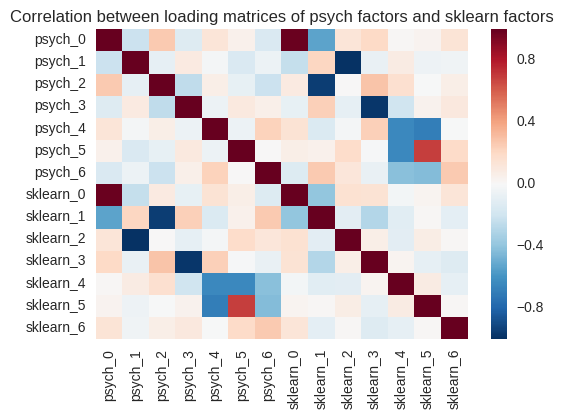

In [90]:
sklearn_loadings = pd.DataFrame(fa.components_.T, columns=['sklearn_%s' % i for i in range(n_components)])
psych_loadings = pd.DataFrame(output['loadings'],columns=['psych_%s' % i for i in range(n_components)])
both_loadings = pd.concat([psych_loadings,sklearn_loadings], axis=1)
# visualize relationship between components
loadings_corr = both_loadings.corr()
sns.heatmap(loadings_corr)
plt.title('Correlation between psych factors and sklearn factors')

In [72]:
# report the sklearn components that have the maximal absolute correlation with the psych components
max_mapping = abs(loadings_corr.iloc[7:,0:7]).max()
best_mapping = abs(loadings_corr.iloc[7:,0:7]).idxmax()
signed_corr = (loadings_corr>0)*2-1
signed_mapping = [signed_corr.loc[i] for i in best_mapping]
print('Highest correlation between components: %s\n' % max_mapping)
print('Best matching component: %s\n' %best_mapping)

Highest correlation between components: psych_0    0.984638
psych_1    0.990667
psych_2    0.946791
psych_3    0.975696
psych_4    0.693679
psych_5    0.690884
psych_6    0.433781
dtype: float64

Best matching component: psych_0    sklearn_0
psych_1    sklearn_2
psych_2    sklearn_1
psych_3    sklearn_3
psych_4    sklearn_5
psych_5    sklearn_5
psych_6    sklearn_5
dtype: object



To interrogate whether the output is the same, look at the loadings of the first variable onto components. The loadings are completely different values

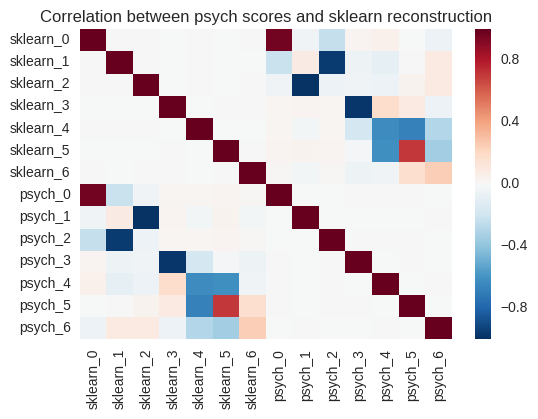

In [91]:
sns.heatmap(pd.concat([scipy_data,psych_data], axis=1).corr())
plt.title('Correlation between psych scores and sklearn reconstruction')